# P5 - Vehicle Detection 
0. Create, Train and Save a Car/Not_Car Classifier
0. Scan each Frame to Find the Cars and Label Them
0. Apply the Pipeline to a stream of images

#### Further Development:
Is it possible to use Parallel platforms and the GPU to solve this problem. Basically the cuda-based implementation of the scikit and skimage would be required

In [242]:
# Import Essential Libraries
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
from skimage.feature import hog
from random import randint
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

## 1. Car/Not_Car Classifier
0. Importing the Training Data
0. Create a Feature Extraction Pipline
0. Apply the Feature Extraction Pipline to Dataset
0. Spliting Dataset to Train, Test and Validation Dataset
0. Train the Classifier with Different Parameters and Choose the Best and Evaluate and save it

### Importing the Training Data

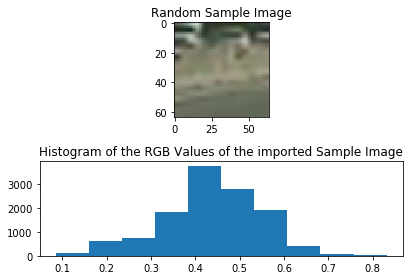

As you can See the imported image pixels has values between 0 and 1.

# Car images: 8792
/media/yousof/Volume/SDC/DataSets/p5/vehicles/GTI_Far/image0378.png
# NotCar images: 8968
/media/yousof/Volume/SDC/DataSets/p5/non-vehicles/Extras/extra1.png


In [2]:
car_dir_path = '/media/yousof/Volume/SDC/DataSets/p5/vehicles'
notcar_dir_path = '/media/yousof/Volume/SDC/DataSets/p5/non-vehicles'

cars_pth = glob.glob(car_dir_path + '*/*/*.png', recursive=True)
notcars_pth = glob.glob(notcar_dir_path + '*/*/*.png', recursive=True)
imgs = cars_pth + notcars_pth

rnd_idx = randint(0,len(imgs)-1)
test_img = mpimg.imread(imgs[rnd_idx])

plt.subplot(211)
plt.imshow(test_img)
plt.title('Random Sample Image')
plt.subplot(212)
plt.title('Histogram of the RGB Values of the imported Sample Image')
# undroll the image and draw the histogram to check the values of the imported image
plt.hist(test_img.ravel())
plt.tight_layout()
plt.show()
print('\x1b[31m'+'As you can See the imported image pixels has values between 0 and 1.'+'\x1b[0m')
print()

# Check if the import, using globe, is correct 
print('# Car images:',len(cars_pth))
print(cars_pth[0])
print('# NotCar images:',len(notcars_pth))
print(notcars_pth[0])

### Feature Extraction Helper

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs,form = 'png', color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if form == 'png':
            image = np.uint8(image*255)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Apply the Feature Extraction to Dataset &  Normalization of the Features

In [4]:
cspace='HLS'
sp_size = (32, 32)
hist_bins = 32
hist_orient_bin = 12
pixelPerCell = 8
cellPerBlock = 2
hogChannel = 0
with_spatial_feat = True
with_hist_feature = True
with_hog_feat = True

In [5]:
features_car = extract_features(cars_pth, form = 'png', color_space=cspace, spatial_size=sp_size,
                     hist_bins=hist_bins, orient=hist_orient_bin,
                     pix_per_cell=pixelPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                     spatial_feat=with_spatial_feat, hist_feat=with_hist_feature, hog_feat=with_hog_feat)

features_notcar = extract_features(notcars_pth, form = 'png', color_space=cspace, spatial_size=sp_size,
                     hist_bins=hist_bins, orient=hist_orient_bin,
                     pix_per_cell=pixelPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                     spatial_feat=with_spatial_feat, hist_feat=with_hist_feature, hog_feat=with_hog_feat)

# get the normalizer
# print(np.isnan(np.array(features_car)).any())
all_features = features_car+features_notcar #
normalizer = StandardScaler().fit(all_features)
nor_features_car = normalizer.transform(features_car)
nor_features_notcar = normalizer.transform(features_notcar)

# save the normaliser
to_save = {"normalizer":normalizer}
pickle.dump( to_save, open( "Normalizer.p", "wb" ) )

/media/yousof/Volume/SDC/Toolkits/anaconda3/envs/carnd_linelane/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3072 96 2352.0


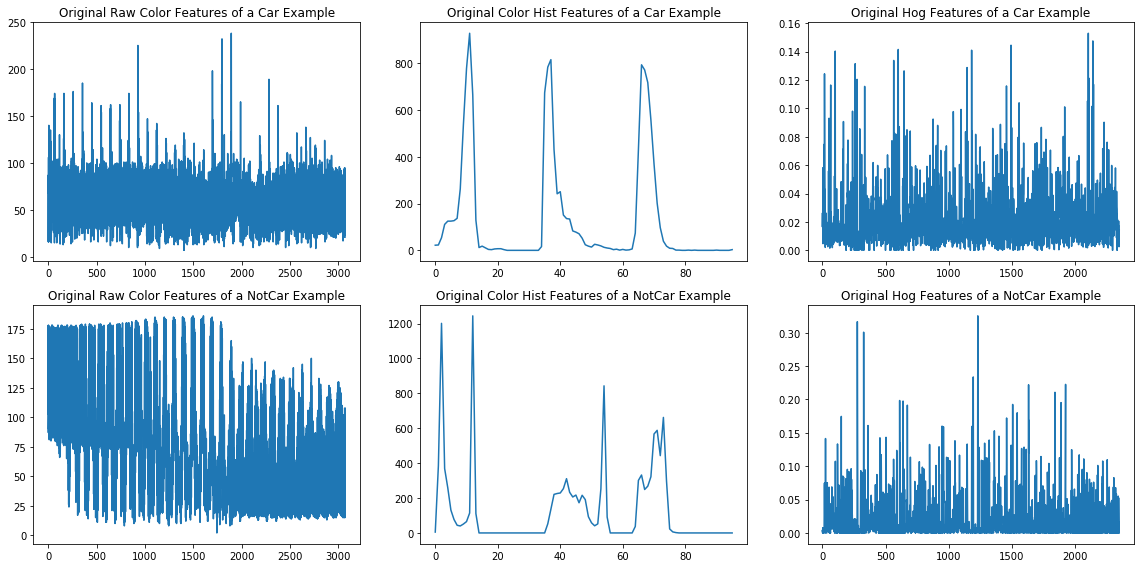

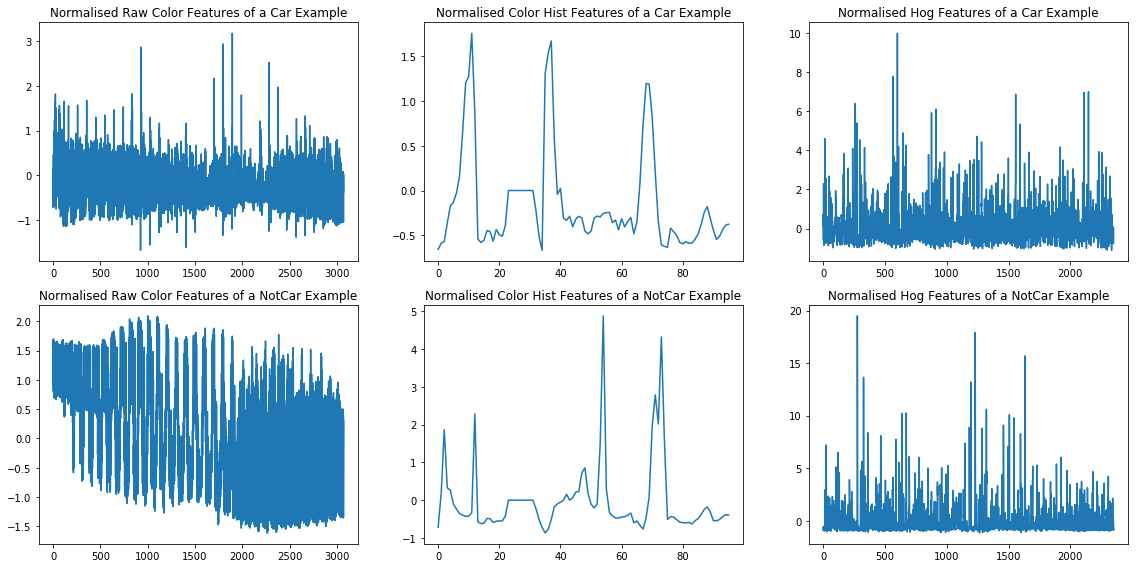

Normalizer Parameters: {'with_mean': True, 'copy': True, 'with_std': True}


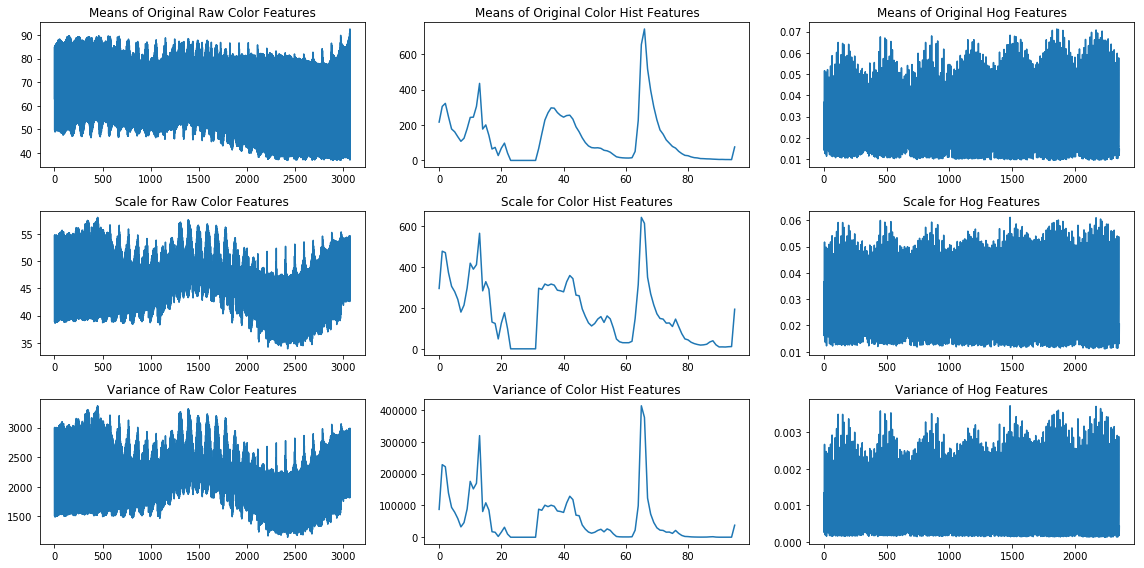

In [6]:
#calculate number of fearures related to each feature
n_bin_spatial_feat = sp_size[0]*sp_size[1]*3
n_color_hist_feat = hist_bins*3
n_hog_feat = ((64/pixelPerCell)-cellPerBlock+1) * ((64/pixelPerCell)-cellPerBlock+1) *\
                    cellPerBlock * cellPerBlock * hist_orient_bin
print(n_bin_spatial_feat,n_color_hist_feat,n_hog_feat)

# exploring the Normalization
id1 = 1452
id2 = 500
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Original Raw Color Features of a Car Example')
plt.plot(np.array(features_car[id1])[:n_bin_spatial_feat])
plt.subplot(232)
plt.title('Original Color Hist Features of a Car Example')
plt.plot(np.array(features_car[id1])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(233)
plt.title('Original Hog Features of a Car Example')
plt.plot(np.array(features_car[id1])[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(234)
plt.title('Original Raw Color Features of a NotCar Example')
plt.plot(np.array(features_notcar[id2])[:n_bin_spatial_feat])
plt.subplot(235)
plt.title('Original Color Hist Features of a NotCar Example')
plt.plot(np.array(features_notcar[id2])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(236)
plt.title('Original Hog Features of a NotCar Example')
plt.plot(np.array(features_notcar[id2])[n_bin_spatial_feat+n_color_hist_feat:])
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Normalised Raw Color Features of a Car Example')
plt.plot(np.array(nor_features_car[id1])[:n_bin_spatial_feat])
plt.subplot(232)
plt.title('Normalised Color Hist Features of a Car Example')
plt.plot(np.array(nor_features_car[id1])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(233)
plt.title('Normalised Hog Features of a Car Example')
plt.plot(np.array(nor_features_car[id1])[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(234)
plt.title('Normalised Raw Color Features of a NotCar Example')
plt.plot(np.array(nor_features_notcar[id2])[:n_bin_spatial_feat])
plt.subplot(235)
plt.title('Normalised Color Hist Features of a NotCar Example')
plt.plot(np.array(nor_features_notcar[id2])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(236)
plt.title('Normalised Hog Features of a NotCar Example')
plt.plot(np.array(nor_features_notcar[id2])[n_bin_spatial_feat+n_color_hist_feat:])
plt.tight_layout()
plt.show()

print('Normalizer Parameters:',normalizer.get_params())

plt.figure(figsize=(16,8))
plt.subplot(331)
plt.title('Means of Original Raw Color Features')
plt.plot(np.array(normalizer.mean_)[:n_bin_spatial_feat])
plt.subplot(332)
plt.title('Means of Original Color Hist Features')
plt.plot(np.array(normalizer.mean_)[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(333)
plt.title('Means of Original Hog Features')
plt.plot(np.array(normalizer.mean_)[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(334)
plt.title('Scale for Raw Color Features')
plt.plot(np.array(normalizer.scale_)[:n_bin_spatial_feat])
plt.subplot(335)
plt.title('Scale for Color Hist Features')
plt.plot(np.array(normalizer.scale_)[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(336)
plt.title('Scale for Hog Features')
plt.plot(np.array(normalizer.scale_)[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(337)
plt.title('Variance of Raw Color Features')
plt.plot(np.array(normalizer.var_)[:n_bin_spatial_feat])
plt.subplot(338)
plt.title('Variance of Color Hist Features')
plt.plot(np.array(normalizer.var_)[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(339)
plt.title('Variance of Hog Features')
plt.plot(np.array(normalizer.var_)[n_bin_spatial_feat+n_color_hist_feat:])
plt.tight_layout()
plt.show()

### Preparing Data to train the classifier

In [7]:
# create the X, Y for classifier
X = np.vstack((nor_features_car, nor_features_notcar)).astype(np.float64)
y = np.hstack((np.ones(len(nor_features_car)), 
              np.zeros(len(nor_features_notcar))))


rand_state = np.random.randint(0, 100)
X,y = shuffle(X, y, random_state=rand_state)

# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

### Train the Classifier with Different Parameters, Choose the Best, Evaluate and Save it

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters,verbose = 10,n_jobs = 4)
clf.fit(X, y)
print('best parameters:')
print(clf.best_params_)

In [ ]:
to_save = {"Classifier":clf}
pickle.dump( to_save, open( "classifier.p", "wb" ) )

In [ ]:
idx = 200
# Predict new data with model loaded from disk
y_x2 = clf.best_estimator_.predict(X[idx])
print(y_x,y_x2,y[idx])

## 2. Scanning Test Frames
0. Load Classifier and Normalizer fron previous section
0. import a test frame 
0. Sliding Window Implementation
0. Scaling the Sliding Windows
0. HeatMap Filtering

### Load the Classfier and Normalizer

In [8]:
# Load model from file
with open('classifier.p', "rb") as pc:
    to_load = pickle.load( pc )
    clf = to_load['Classifier']

with open('Normalizer.p', "rb") as pc:
    to_load = pickle.load( pc )
    normalizer = to_load['normalizer']

print(clf.best_estimator_)
print(normalizer)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
StandardScaler(copy=True, with_mean=True, with_std=True)


### import a test frame

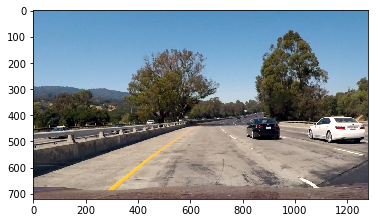

In [177]:
tst_fram_path = '/media/yousof/Volume/SDC/Gits/CarND-Vehicle-Detection/test_images'
tst_fram_path = glob.glob(tst_fram_path + '/*.jpg', recursive=True)

tst_frame = mpimg.imread(tst_fram_path[0])
plt.imshow(tst_frame)
plt.show()
image = tst_frame.copy()

### Sliding Windows Implementation and Searching Windows for Cars

In [250]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

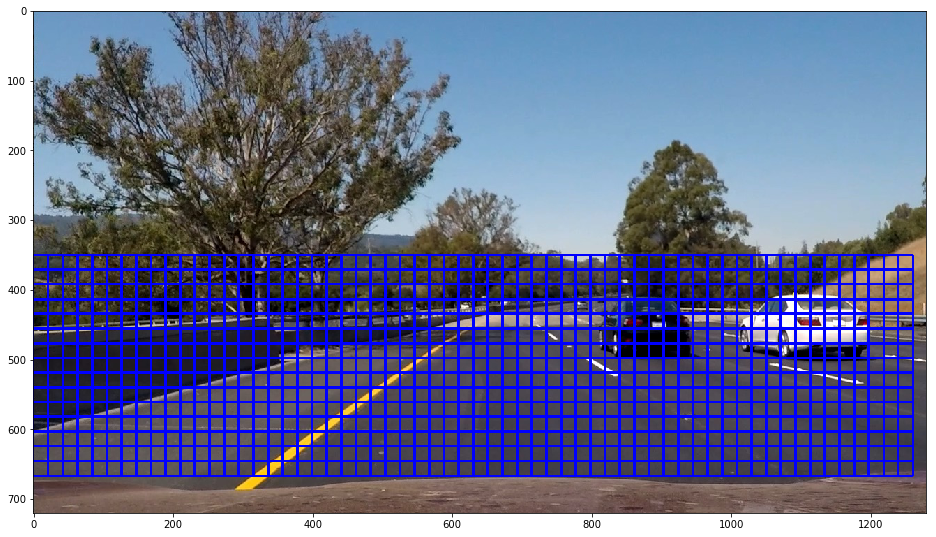

In [134]:
y_start_stop = np.array([350, 680]) # 350, 680
x_start_stop = np.array([None, None])

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                       xy_window=(64, 64), xy_overlap=(0.66, 0.66))
window_img = image.copy()

window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=2)
plt.figure(figsize=(16,10))
plt.imshow(window_img)
plt.show()

/media/yousof/Volume/SDC/Toolkits/anaconda3/envs/carnd_linelane/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


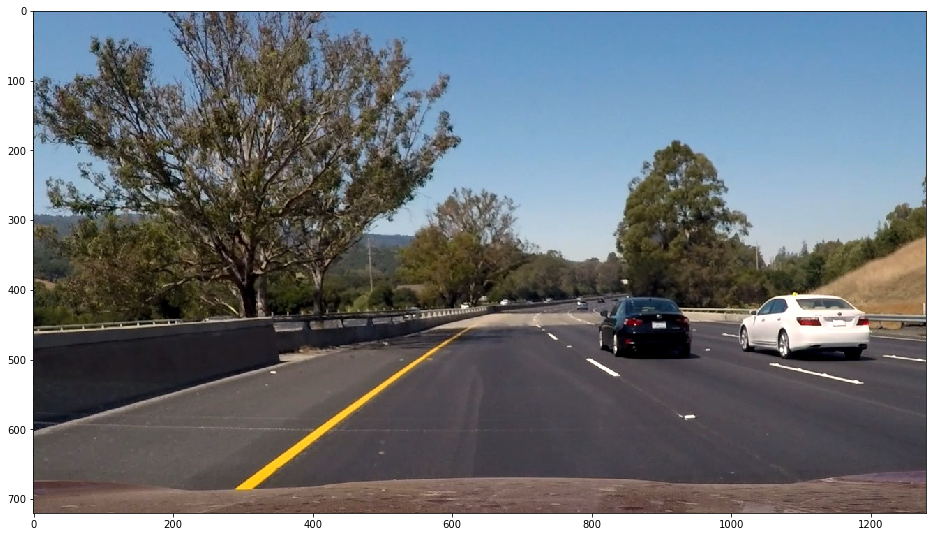

In [133]:
# test one size
draw_image = image.copy()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.66, 0.66))

hot_windows = search_windows(image, windows, clf.best_estimator_, normalizer, color_space=cspace, 
                        spatial_size=sp_size, hist_bins=hist_bins, 
                        orient=hist_orient_bin, pix_per_cell=pixelPerCell, 
                        cell_per_block=cellPerBlock, 
                        hog_channel=hogChannel, spatial_feat=with_spatial_feat, 
                        hist_feat=with_hist_feature, hog_feat=with_hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    

plt.figure(figsize=(16,10))
plt.imshow(window_img)
plt.show()

### Scaling the Sliding Windows

# Windows: 131
# scales: 131


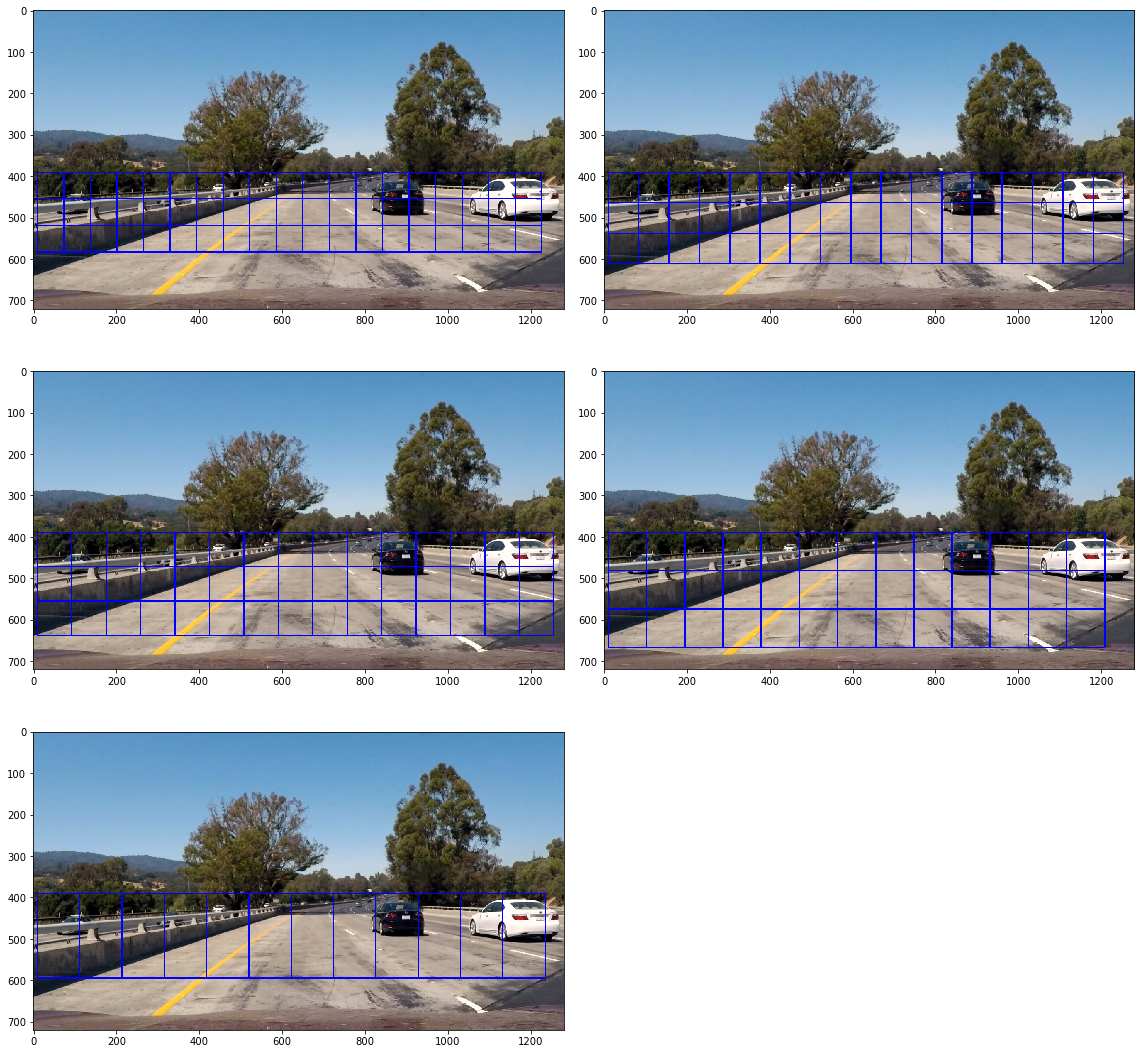

In [262]:
#scaling windows

window_img = image.copy()
y_start_stop = np.array([350, 680]) # 350, 680
x_start_stop = np.array([10, None])

scale_list = np.arange(1,1.6,0.15)
overlapX_list= np.linspace(0.5,0.8,num=scale_list.shape[0])
overlapY_list= overlapX_list *0.9 
size_list = scale_list * 128
horiton_y = 390
ratio_hori = 1/3

windows = []
windows_scale_to_64 = []
one_size_window=[None]*len(size_list)

plt.figure(figsize=(16,25))

for idx, size in enumerate(size_list):
    y_start_stop=np.array([max(horiton_y , 350), min(horiton_y+(1+0.5)*size ,680)],dtype=np.int)
    
    windows_for_this_size = slide_window(image, 
                                         x_start_stop= x_start_stop, y_start_stop= y_start_stop,
                                         xy_window=(int(size), int(size)),#*0.8 
                                         xy_overlap=(0.5, 0.5)) 
    
    # xy_overlap=(overlapX_list[idx], overlapY_list[idx])
    one_size_window[idx] = windows_for_this_size 

    windows=windows+windows_for_this_size
    windows_scale_to_64 = windows_scale_to_64 + [scale_list[idx]*2]*len(windows_for_this_size)
    window_img = draw_boxes(image, one_size_window[idx], color=(0, 0, 255), thick=2)
    plt.subplot(521 + idx)
    plt.imshow(window_img)
print('# Windows:',len(windows))
print('# scales:',len(windows_scale_to_64))
plt.tight_layout()
plt.show()

### Test the Scaled Windows on the Test Image

instead of having scaling windows, we can have scaling images and fix size windows

In [ ]:
def single_img_features2(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_features,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows2(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    # Compute individual channel HOG features for the entire image
    hog_for_different_scales =[]
    for scale_id ,scale in enumerate(scale_list):
        cv2.resize()
        hog_for_different_scales[scale_id]= get_hog_features(img2search, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        hog_subsample = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_features=hog_subsample, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

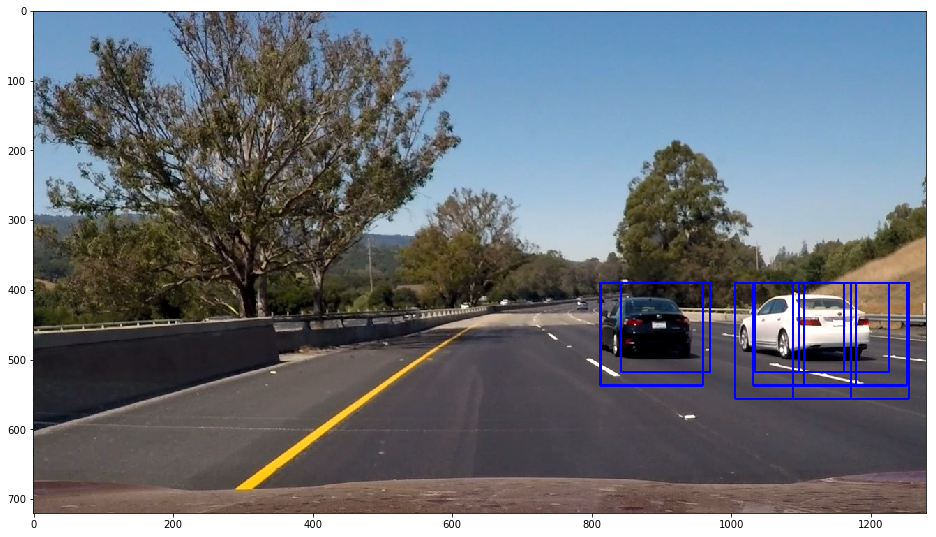

In [256]:
hot_windows = search_windows(image, windows, clf.best_estimator_, normalizer, color_space=cspace, 
                        spatial_size=sp_size, hist_bins=hist_bins, 
                        orient=hist_orient_bin, pix_per_cell=pixelPerCell, 
                        cell_per_block=cellPerBlock, 
                        hog_channel=hogChannel, spatial_feat=with_spatial_feat, 
                        hist_feat=with_hist_feature, hog_feat=with_hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    

plt.figure(figsize=(16,10))
plt.imshow(window_img)
plt.show()

### HeatMap Generation

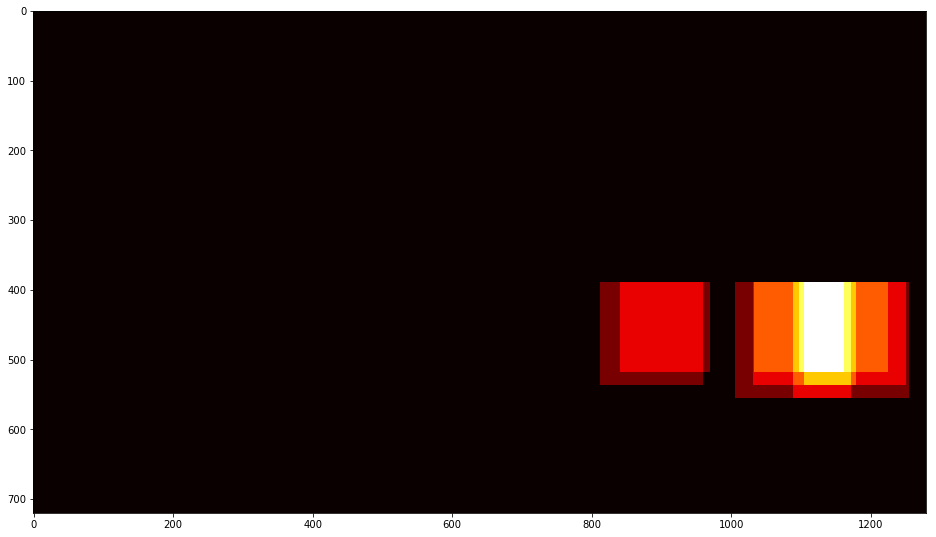

In [257]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    hm = np.copy(heatmap)
    hm[heatmap <= threshold] = 0
    # Return thresholded map
    return hm

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
heatmap = np.clip(heat, 0, 255)

plt.figure(figsize=(16,10))
plt.imshow(heatmap,cmap='hot')
plt.show()

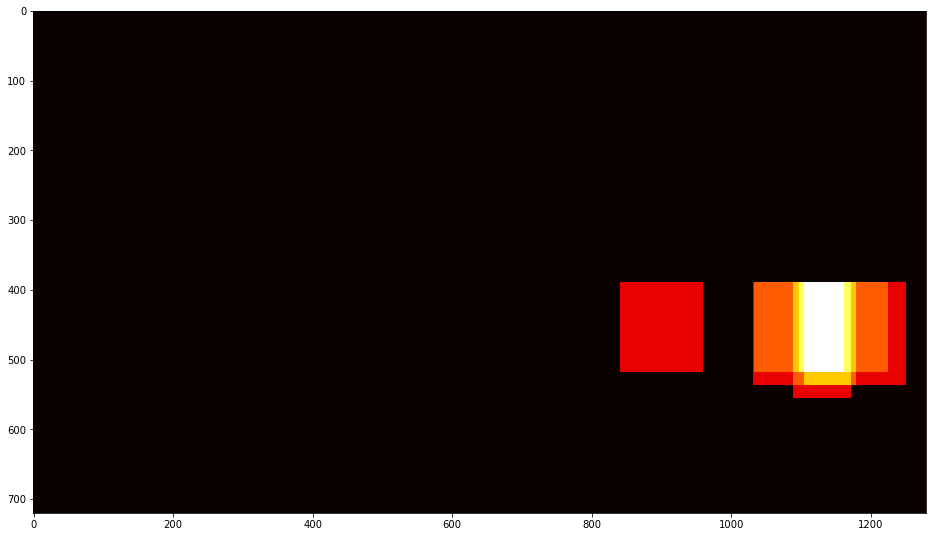

In [258]:
heat_thresholded = apply_threshold(heat,1)
plt.figure(figsize=(16,10))
plt.imshow(heat_thresholded,cmap='hot')
plt.show()

### Filter the HeatMap for a Box per each object

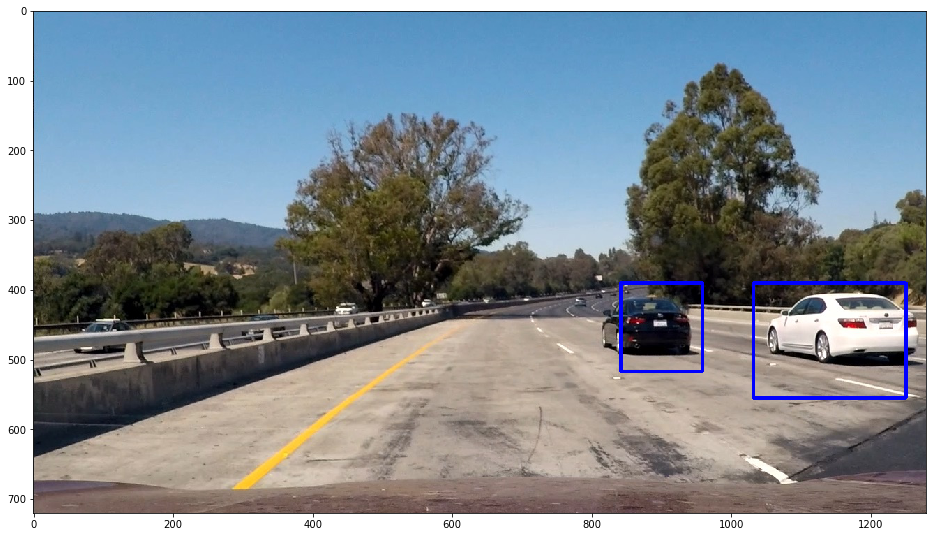

In [259]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img


labels = label(heat_thresholded)
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.figure(figsize=(16,10))
#Display the image
plt.imshow(draw_img)
plt.show()

# Pipeline to implement to the Video

In [240]:
def detect_cars(img):
    hot_windows = search_windows(img, windows, clf.best_estimator_, normalizer, color_space=cspace, 
                        spatial_size=sp_size, hist_bins=hist_bins, 
                        orient=hist_orient_bin, pix_per_cell=pixelPerCell, 
                        cell_per_block=cellPerBlock, 
                        hog_channel=hogChannel, spatial_feat=with_spatial_feat, 
                        hist_feat=with_hist_feature, hog_feat=with_hog_feat)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heatmap = np.clip(heat, 0, 255)
    heat_thresholded = apply_threshold(heat,1)
    labels = label(heat_thresholded)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [245]:
output = 'test_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(detect_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_out.mp4
[MoviePy] Writing video test_out.mp4



 97%|█████████▋| 38/39 [06:05<00:09,  9.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out.mp4 

CPU times: user 6min 3s, sys: 332 ms, total: 6min 4s
Wall time: 6min 6s
